# Segmenting remote sensing imagery with text prompts and the Segment Anything Model (SAM)

This notebook shows how to generate object masks from text prompts with the Segment Anything Model (SAM). Make sure you use GPU runtime for this notebook. 

## Setup

In [1]:
# Import the os module
import os

path = 'tmp/'

try:
    os.chdir(path)
    print("Current working directory: {0}".format(os.getcwd()))
except FileNotFoundError:
    print("Directory: {0} does not exist".format(path))
except NotADirectoryError:
    print("{0} is not a directory".format(path))
except PermissionError:
    print("You do not have permissions to change to {0}".format(path))

Current working directory: /home/ec2-user/SageMaker/ODP_Demo/tmp


## Call Libs

In [2]:
import leafmap
from samgeo import tms_to_geotiff
from samgeo.text_sam import LangSAM

## Create an interactive map

In [3]:
m = leafmap.Map(center=[-22.17615, -51.253043], zoom=18, height="800px")
m.add_basemap("SATELLITE")
m.attribution_control=False
m

Map(center=[-22.17615, -51.253043], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

## Download a sample image

Pan and zoom the map to select the area of interest. Use the draw tools to draw a polygon or rectangle on the map

In [4]:
bbox = m.user_roi_bounds()
if bbox is None:
    bbox = [-51.2565, -22.1777, -51.2512, -22.175]

In [5]:
image = "Image.tif"
tms_to_geotiff(output=image, bbox=bbox, zoom=19, source="Satellite", overwrite=True)

Downloaded image 01/45
Downloaded image 02/45
Downloaded image 03/45
Downloaded image 04/45
Downloaded image 05/45
Downloaded image 06/45
Downloaded image 07/45
Downloaded image 08/45
Downloaded image 09/45
Downloaded image 10/45
Downloaded image 11/45
Downloaded image 12/45
Downloaded image 13/45
Downloaded image 14/45
Downloaded image 15/45
Downloaded image 16/45
Downloaded image 17/45
Downloaded image 18/45
Downloaded image 19/45
Downloaded image 20/45
Downloaded image 21/45
Downloaded image 22/45
Downloaded image 23/45
Downloaded image 24/45
Downloaded image 25/45
Downloaded image 26/45
Downloaded image 27/45
Downloaded image 28/45
Downloaded image 29/45
Downloaded image 30/45
Downloaded image 31/45
Downloaded image 32/45
Downloaded image 33/45
Downloaded image 34/45
Downloaded image 35/45
Downloaded image 36/45
Downloaded image 37/45
Downloaded image 38/45
Downloaded image 39/45
Downloaded image 40/45
Downloaded image 41/45
Downloaded image 42/45
Downloaded image 43/45
Downloaded 

You can also use your own image. Uncomment and run the following cell to use your own image.

In [6]:
# image = '/path/to/your/own/image.tif'

Display the downloaded image on the map.

In [7]:
m.layers[-1].visible = False
m.add_raster(image, layer_name="Image")
m

Map(center=[-22.17615, -51.253043], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

## Free Cuda Memory

In [ ]:
import torch
torch.cuda.empty_cache()

## Initialize LangSAM class

The initialization of the LangSAM class might take a few minutes. The initialization downloads the model weights and sets up the model for inference.

In [8]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Specify text prompts

In [9]:
text_prompt = "tree"

## Segment the image

Part of the model prediction includes setting appropriate thresholds for object detection and text association with the detected objects. These threshold values range from 0 to 1 and are set while calling the predict method of the LangSAM class.

`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

`text_threshold`: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

Remember to test different threshold values on your specific data. The optimal threshold can vary depending on the quality and nature of your images, as well as the specificity of your text prompts. Make sure to choose a balance that suits your requirements, whether that's precision or recall.

In [10]:
sam.predict(image, text_prompt, box_threshold=0.24, text_threshold=0.24)

## Visualize the results

Show the result with bounding boxes on the map.

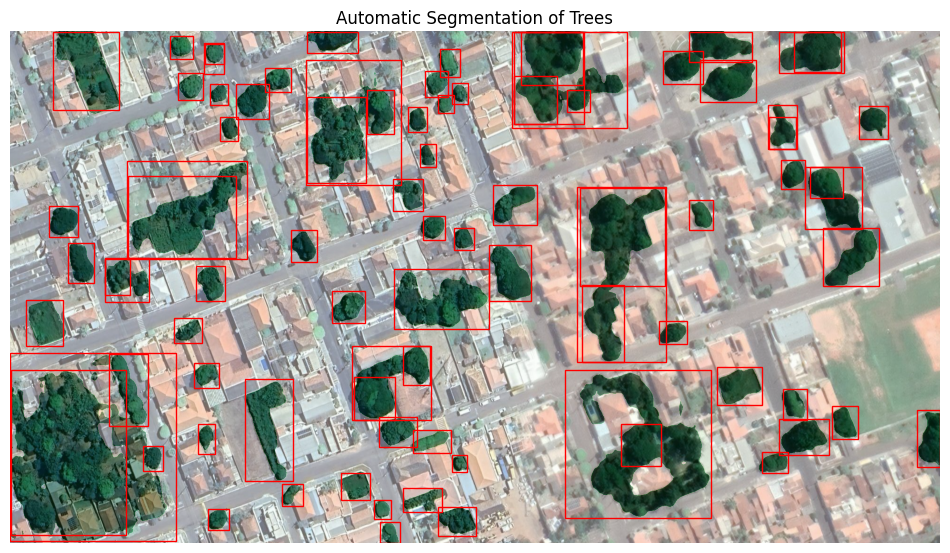

In [11]:
sam.show_anns(
    cmap='Greens',
    box_color='red',
    title='Automatic Segmentation of Trees',
    blend=True,
)

![](https://i.imgur.com/ytKMTlA.png)

Show the result without bounding boxes on the map.

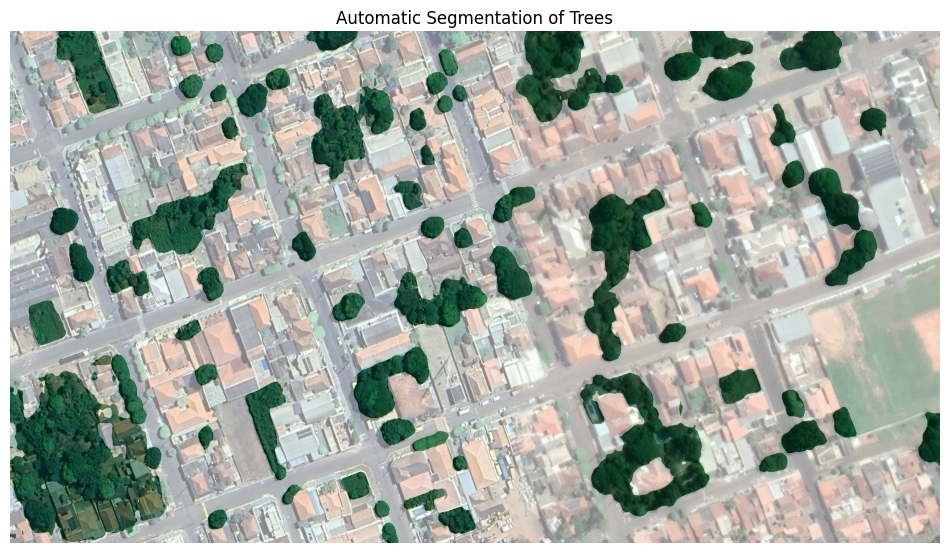

In [12]:
sam.show_anns(
    cmap='Greens',
    add_boxes=False,
    alpha=0.5,
    title='Automatic Segmentation of Trees',
)

![](https://i.imgur.com/3Iq2kt1.png)

Show the result as a grayscale image.

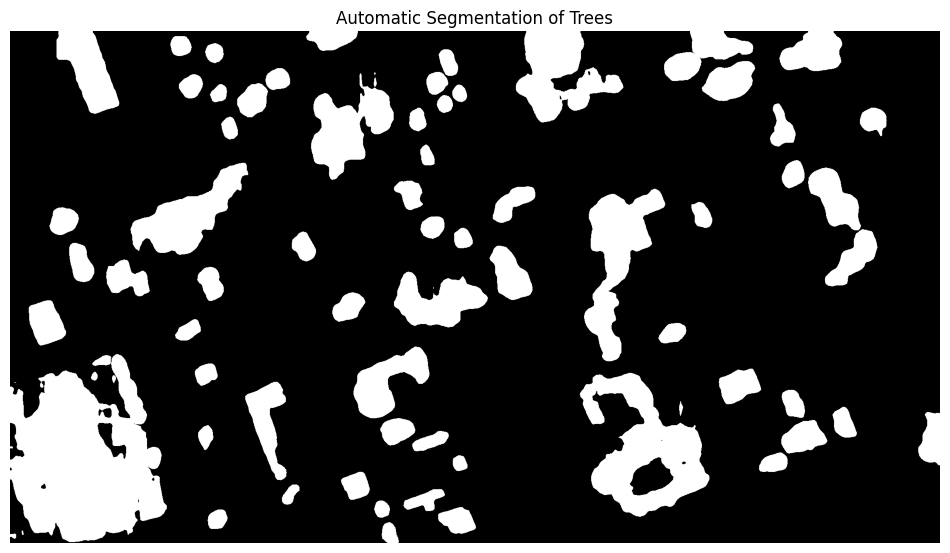

In [13]:
sam.show_anns(
    cmap='Greys_r',
    add_boxes=False,
    alpha=1,
    title='Automatic Segmentation of Trees',
    blend=False,
    output='trees.tif',
)

![](https://i.imgur.com/KtHwFbF.png)

Convert the result to a vector format.  

In [14]:
sam.raster_to_vector("trees.tif", "trees.shp")

Show the results on the interactive map.

In [15]:
m.add_raster("trees.tif", layer_name="Trees", palette="Greens", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector("trees.shp", layer_name="Vector", style=style)
m

Map(center=[-22.176349999999996, -51.25385], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_…

## Interactive segmentation

In [19]:
sam.show_map(
    center=[-22.17615, -51.253043],
    attribution_control=False
)

Map(center=[-22.17615, -51.253043], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

![](https://i.imgur.com/wydt5Xt.gif)